In [5]:
import numpy as np
import pandas as pd
import os
import glob
import shutil
from IPython.display import clear_output

summary_files = glob.glob('../../../aldd_results/params_results/*/*/*/*/summary.csv')
p0 = np.unique([f.split('\\')[-3] for f in summary_files])

In [6]:
res_df_list = [[], [], []]
failed_jobs = []
all_jobs = []
for i, s_file in enumerate(summary_files):
    clear_output()
    print('{}/{}'.format(i, len(summary_files)))
    s_params = s_file.split('\\')
    config_file = s_file.replace('summary.csv', 'config.csv')
    dist_type = s_params[1]
    exploration_strategy = s_params[2]
    hs_name = s_params[3]
    batch_size = s_params[4]
    
    hs_info = [dist_type, exploration_strategy, hs_name, batch_size, config_file]
    hs_id = '{}_{}_{}_{}'.format(dist_type, exploration_strategy, hs_name, batch_size)
    
    all_jobs.append(hs_id)
    
    df = pd.read_csv(s_file, index_col=0)
    bsize_df = df[['exploitation_batch_size', 'exploration_batch_size']]
    exploit_df = df[[m for m in df.columns if 'exploitation_hits_at_' in m]].sum(axis=1).to_frame(name='exploitation_hits')
    explore_df = df[[m for m in df.columns if 'exploration_hits_at_' in m]].sum(axis=1).to_frame(name='exploration_hits')
    exploit_max_df = df[[m for m in df.columns if 'exploitation_max_hits_at_' in m]].sum(axis=1).to_frame(name='exploitation_max_hits')
    explore_max_df = df[[m for m in df.columns if 'exploration_max_hits_at_' in m]].sum(axis=1).to_frame(name='exploration_max_hits')
    
    sum_df = pd.concat([bsize_df, exploit_df, exploit_max_df, explore_df, explore_max_df], axis=1)
    sum_df['total_batch_size'] = sum_df['exploitation_batch_size'] + sum_df['exploration_batch_size']
    sum_df['total_hits'] = sum_df['exploitation_hits'] + sum_df['exploration_hits']
    sum_df['total_max_hits'] = sum_df['exploitation_max_hits'] + sum_df['exploration_max_hits']
    sum_df['total_max_hits'] = sum_df['total_max_hits'].apply((lambda x: min(x, int(batch_size.split('_')[-1]))))
    
    sum_df.iloc[-1,:] = sum_df.iloc[:-1,:].sum(axis=0)
    sum_df['iteration'] = list(range(10)) + [9999]
    sum_df['hyperparameter_id'] = hs_id
    sum_df.index = list(range(10)) + ['total']
    
    sum_df['config_file'] = config_file
    
    if batch_size == 'batch_size_96':
        res_df_list[0].append(sum_df)
    elif batch_size == 'batch_size_384':
        res_df_list[1].append(sum_df)
    else:
        res_df_list[2].append(sum_df)

all_0 = pd.concat(res_df_list[0])
all_1 = pd.concat(res_df_list[1])
all_2 = pd.concat(res_df_list[2])
all_0['hits_to_batch_size_ratio'] = all_0['total_hits'] / all_0['total_batch_size']
all_1['hits_to_batch_size_ratio'] = all_1['total_hits'] / all_1['total_batch_size']
all_2['hits_to_batch_size_ratio'] = all_2['total_hits'] / all_2['total_batch_size']
all_df = pd.concat([all_0, all_1, all_2])

1502/1503


In [7]:
print('Total hs: {}'.format(len(all_jobs)))
print('Failed hs: {}'.format(len(failed_jobs)))
print('Successfull hs: {}'.format(len(all_jobs) - len(failed_jobs)))

Total hs: 1503
Failed hs: 0
Successfull hs: 1503


---
# Plots

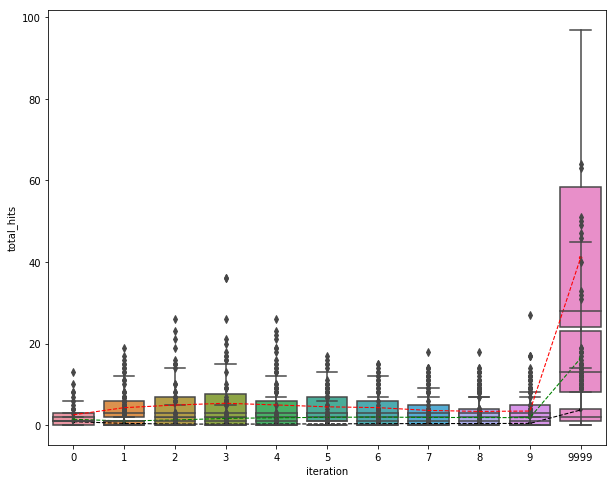

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.boxplot(x="iteration", y="total_hits", data=all_0)
sns.pointplot(x="iteration", y="total_hits", data=all_0, linestyles='--', scale=0.4, 
              color='k', errwidth=0, capsize=0)

sns.boxplot(x="iteration", y="total_hits", data=all_1)
sns.pointplot(x="iteration", y="total_hits", data=all_1, linestyles='--', scale=0.4, 
              color='g', errwidth=0, capsize=0)

sns.boxplot(x="iteration", y="total_hits", data=all_2)
sns.pointplot(x="iteration", y="total_hits", data=all_2, linestyles='--', scale=0.4, 
              color='r', errwidth=0, capsize=0)

plt.show()

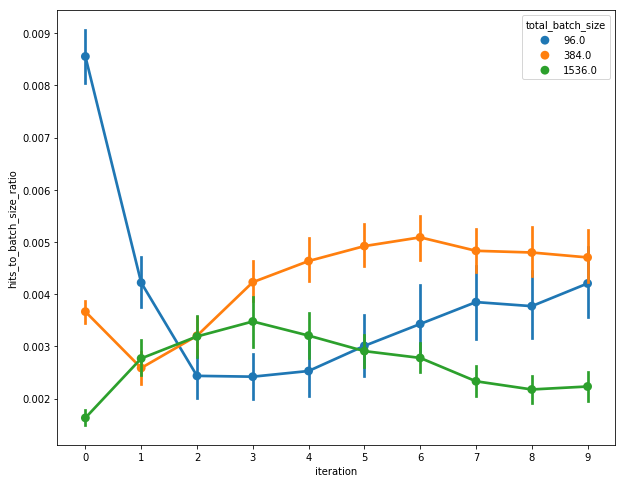

In [35]:
plt.figure(figsize=(10, 8))
#sns.boxplot(x="iteration", y="hits_to_batch_size_ratio", data=all_0)
sns.pointplot(x="iteration", y="hits_to_batch_size_ratio", hue="total_batch_size", data=all_df.drop('total'))
plt.show()

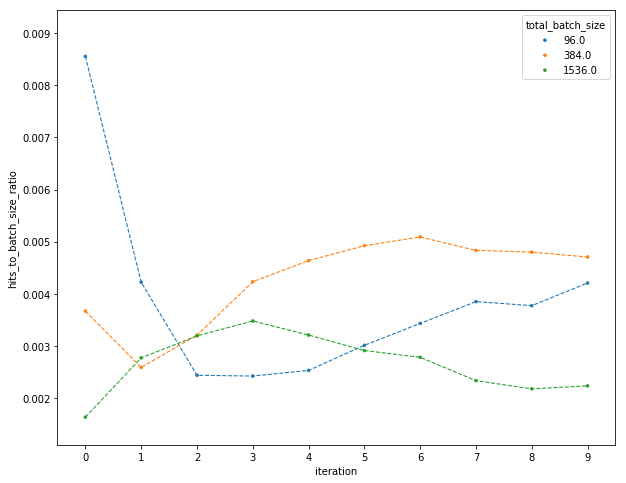

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.pointplot(x="iteration", y="hits_to_batch_size_ratio", hue="total_batch_size", 
              data=all_df.drop('total'), linestyles='--', scale=0.4, errwidth=0, capsize=0)
plt.show()

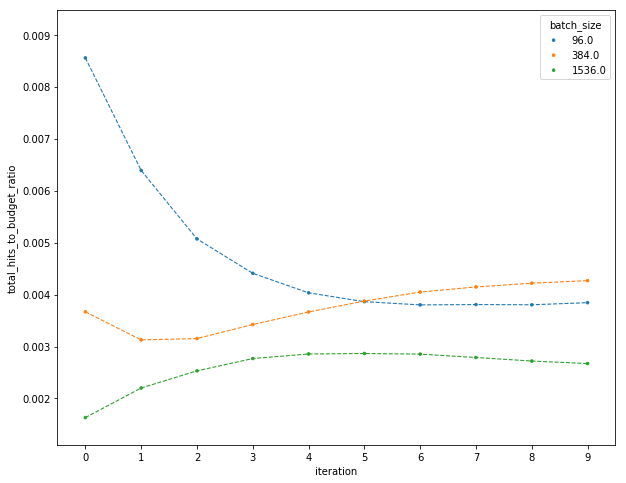

In [37]:
running_sum = all_df.drop('total').groupby('hyperparameter_id').cumsum(axis=0)
running_sum['total_hits_to_budget_ratio'] = running_sum['total_hits'] / running_sum['total_batch_size']
running_sum['batch_size'] = all_df.drop('total')['total_batch_size']
running_sum['iteration'] = all_df.drop('total')['iteration']

plt.figure(figsize=(10, 8))
sns.pointplot(x="iteration", y="total_hits_to_budget_ratio", hue="batch_size", 
              data=running_sum, 
              linestyles='--', scale=0.4, errwidth=0, capsize=0)
plt.show()

---
# In-Depth

In [4]:
top_hs_0 = all_0[all_0['iteration'] == 9999].sort_values('total_hits')
top_hs_0 = top_hs_0[top_hs_0['total_hits'] >= np.quantile(top_hs_0['total_hits'], 0.98)]
top_hs_0 = top_hs_0.reset_index(drop=True)

top_hs_1 = all_1[all_1['iteration'] == 9999].sort_values('total_hits')
top_hs_1 = top_hs_1[top_hs_1['total_hits'] >= np.quantile(top_hs_1['total_hits'], 0.95)]
top_hs_1 = top_hs_1.reset_index(drop=True)

top_hs_2 = all_2[all_2['iteration'] == 9999].sort_values('total_hits')
top_hs_2 = top_hs_2[top_hs_2['total_hits'] >= np.quantile(top_hs_2['total_hits'], 0.98)]
top_hs_2 = top_hs_2.reset_index(drop=True)

---
### DTK tests for hyperparameters
Null Hypothesis: Groups have same mean.

If confidence interval does not contain 0, then we REJECT null hypothesis; i.e. groups do not have same mean.

In [181]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages

# Null Hypothesis: Groups have same mean
# If confidence interval does not contain 0, then we REJECT null hypothesis

dtk_lib = rpackages.importr('DTK')
alpha=0.05

def get_important_hs(top_hs):
    config_df = pd.concat([pd.read_csv(x) for x in top_hs['config_file']])
    config_df = config_df.reset_index(drop=True)
    req_cols = config_df.columns[2:-4]

    dtk_dict = {}
    for c in req_cols:
        df = pd.concat([top_hs['total_hits'], config_df[c]], axis=1)

        group_names = list(np.sort(df[c].unique()))
        group_means = df.groupby(c).mean()
        index_names_1 = []
        index_names_2 = []
        mean1 = []
        mean2 = []
        for i in range(len(group_names)):
            for j in range(i+1, len(group_names)):
                index_names_1.append(group_names[j])
                index_names_2.append(group_names[i])
                mean1.append(group_means.iloc[j,0])
                mean2.append(group_means.iloc[i,0])

        m_df_mat = np.around(df['total_hits'].as_matrix(), decimals=4)
        dtk_results_init = dtk_lib.DTK_test(robjects.FloatVector(m_df_mat), robjects.FactorVector(df[c].tolist()), alpha)
        dtk_results = np.array(dtk_results_init[1])        
        dtk_pd = pd.DataFrame(data=[index_names_1, index_names_2, 
                                    list(mean1), list(mean2),
                                    list(dtk_results[:,0]),list(dtk_results[:,1]),
                                    list(dtk_results[:,2]), [False for _ in range(len(index_names_1))]]).T
        dtk_pd.columns = ['group1', 'group2', 'mean1', 'mean2', 'meandiff', 'Lower CI', 'Upper CI', 'reject']
        for j in range(dtk_pd.shape[0]):      
            if dtk_pd.loc[j,'Lower CI'] > 0 or dtk_pd.loc[j,'Upper CI'] < 0:
                dtk_pd.loc[j,'reject'] = True

        if True in list(dtk_pd['reject']):
            dtk_dict[c] = dtk_pd

    important_hs = {}
    for k in dtk_dict:
        dtk_pd = dtk_dict[k]
        g1_max = dtk_pd[dtk_pd['mean1'] == dtk_pd['mean1'].max()].iloc[0,:]
        g2_max = dtk_pd[dtk_pd['mean2'] == dtk_pd['mean2'].max()].iloc[0,:]
        if g1_max['mean1'] > g2_max['mean2']:
            important_hs[k] = g1_max['group1']
        else:
            important_hs[k] = g1_max['group2']
            
    return important_hs

In [182]:
top_hs_0 = all_0[all_0['iteration'] == 9999].sort_values('total_hits')
top_hs_0 = top_hs_0.reset_index(drop=True)
important_hs_0 = get_important_hs(top_hs_0)

top_hs_1 = all_1[all_1['iteration'] == 9999].sort_values('total_hits')
top_hs_1 = top_hs_1.reset_index(drop=True)
important_hs_1 = get_important_hs(top_hs_1)

top_hs_2 = all_2[all_2['iteration'] == 9999].sort_values('total_hits')
top_hs_2 = top_hs_2.reset_index(drop=True)
important_hs_2 = get_important_hs(top_hs_2)

C:\Users\Moeman\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Moeman\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Moeman\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [ ]:
for c in req_cols:
    df = pd.concat([top_hs['total_hits'], config_df[c]], axis=1)
    values = list(df[c].unique())
    print(c)
    for x in values:
        sns.distplot(df[df[c] == x]['total_hits'])
    plt.legend(values)
    plt.show()
    
    print('--------------------------------------------')

In [211]:
top_hs_0 = all_0[all_0['iteration'] == 9999].sort_values('total_hits')
top_hs_0 = top_hs_0.reset_index(drop=True)

top_hs_1 = all_1[all_1['iteration'] == 9999].sort_values('total_hits')
top_hs_1 = top_hs_1.reset_index(drop=True)

top_hs_2 = all_2[all_2['iteration'] == 9999].sort_values('total_hits')
top_hs_2 = top_hs_2.reset_index(drop=True)

,class,batch_size,exploitation_use_quantile_for_activity,exploitation_sample_actives_from_clusters,exploitation_activity_threshold,exploitation_use_quantile_for_weight,exploitation_weight_threshold,exploitation_alpha,exploitation_dissimilarity_lambda,use_intra_cluster_threshold_for_exploitation,...,exploration_beta,exploration_dissimilarity_lambda,use_intra_cluster_threshold_for_exploration,use_proportional_cluster_budget_for_exploration,select_dissimilar_instances_within_cluster,intra_cluster_dissimilarity_threshold,feature_dist_func,use_consensus_distance,uncertainty_method,rnd_seed
0,ClusterBasedWCSelector,96,False,True,0.75,False,0.75,0.0,0.25,False,...,1.0,1.0,True,False,True,0.2,tanimoto_dissimilarity,True,least_confidence,182653426


In [179]:
best_hit[['total_batch_size', 'total_hits']]

,total_batch_size,total_hits
18,960.0,40.0
32,3840.0,64.0
3,15360.0,97.0


---
# Prepare config files for Experiment 1
Run the top-20 hyperparameters from each batch size with different starting initial 96 plate.
Number of different initial starts: 10.
Total of 30(hyperparams)\*3(batch_sizes)\*10(initial plates) =  runs

In [9]:
import pathlib
import json

top_hs_0 = all_0[all_0['iteration'] == 9999].sort_values('total_hits')
top_hs_0 = top_hs_0.reset_index(drop=True)

top_hs_1 = all_1[all_1['iteration'] == 9999].sort_values('total_hits')
top_hs_1 = top_hs_1.reset_index(drop=True)

top_hs_2 = all_2[all_2['iteration'] == 9999].sort_values('total_hits')
top_hs_2 = top_hs_2.reset_index(drop=True)

config_dir = '../param_configs/first_pass_hyperparams/batch_size_{}/'
for bsize, top_hs in zip([96, 384, 1536], 
                         [top_hs_0.iloc[-20:,:], top_hs_1.iloc[-20:,:], top_hs_2.iloc[-20:,:]]):
    cf_dir = config_dir.format(bsize)
    pathlib.Path(cf_dir).mkdir(parents=True, exist_ok=True)
        
    config_files = top_hs['config_file']
    hs_ids = top_hs['hyperparameter_id'].apply((lambda x: '_'.join(x.split('_')[2:4])))
    for hid, cf in zip(hs_ids, config_files):
        cdf = pd.read_csv(cf)
        cdf = cdf.iloc[0].to_dict()
        cdf['batch_size'] = [96, 384, 1536]
        cdf['hyperparameter_id'] = hid
        
        for k in cdf:
            if type(cdf[k]) == np.bool_:
                cdf[k] = bool(cdf[k])
            elif type(cdf[k]) == np.int64:
                cdf[k] = int(cdf[k])
            elif type(cdf[k]) == np.float64:
                cdf[k] = float(cdf[k])  
        with open(cf_dir + hid+'.json', 'w') as f:
            json.dump(cdf, f)

In [296]:
csv_files = glob.glob('../datasets/lc_clusters_cv_96/*.csv')
files_with_actives = []
for c in csv_files:
    df = pd.read_csv(c)
    if df['PriA-SSB Activity'].sum() > 0:
        files_with_actives.append(c)
files_with_actives = [f for f in files_with_actives if 'unlabeled_0.csv' not in f]
random_active_files = list(np.random.choice(files_with_actives, size=10, replace=False))

In [3]:
import pathlib, os, shutil, glob
import json
import pandas as pd
import numpy as np

random_active_files = ['../datasets/lc_clusters_cv_96\\unlabeled_33.csv',
                       '../datasets/lc_clusters_cv_96\\unlabeled_47.csv',
                       '../datasets/lc_clusters_cv_96\\unlabeled_76.csv',
                       '../datasets/lc_clusters_cv_96\\unlabeled_77.csv',
                       '../datasets/lc_clusters_cv_96\\unlabeled_50.csv',
                       '../datasets/lc_clusters_cv_96\\unlabeled_6.csv',
                       '../datasets/lc_clusters_cv_96\\unlabeled_40.csv',
                       '../datasets/lc_clusters_cv_96\\unlabeled_59.csv',
                       '../datasets/lc_clusters_cv_96\\unlabeled_129.csv',
                       '../datasets/lc_clusters_cv_96\\unlabeled_53.csv']
hparams_files = glob.glob('../param_configs/first_pass_hyperparams/*/*.json')